# Flow Matching 튜토리얼: Diffusion 모델과 같은 ODE 생성 모델 학습

## 소개

**Flow Matching은 세 개의 다른 ICLR 2023 논문에서 소개되었으며 최근 머신 러닝 커뮤니티에서 많은 관심을 받고 있습니다. 여기서는 다음 논문들을 모두 강조하고 싶습니다: Flow Matching [(Lipman et al.)](https://arxiv.org/abs/2210.02747), Stochastic Interpolants [(Albergo et al.)](https://arxiv.org/abs/2209.15571) 및 Rectified Flow [(Liu et al.)](https://arxiv.org/abs/2209.03003).**

Flow Matching은 최근 도입된 생성 모델로, 상미분 방정식(ODE)을 활용하여 기본 밀도를 원하는 데이터 분포로 변형합니다. 반면 Diffusion은 확률 미분 방정식(SDE)을 기반으로 합니다. 이 노트북에서는 Flow Matching 방법의 학습을 설명하고 주요 구성 요소를 강조합니다. 이 노트북에서는 여러 공식과 Flow Matching 선택에 기반한 Flow Matching 모델을 구축할 것입니다:
* 독립 조건부 Flow Matching (Independent Conditional Flow Matching, I-CFM)
* 최적 운송 조건부 Flow Matching (Optimal Transport Conditional Flow Matching, OT-CFM)

우리의 표기법에서 $\alpha$는 노이즈 분포(일반적으로 가우스)를 나타내며, $\beta$는 실제 데이터에 해당하는 분포를 나타냅니다.

## ODE: 데이터 분포를 다른 분포로 변환하기

기본적인 개념을 살펴보겠습니다. 우리는 상미분 방정식을 정의하는 부드러운 시변 벡터 필드 $u : [0, 1] \times \mathbb{R}^d \to \mathbb{R}^d$를 고려합니다:
$$
dx = u_t(x)\,dt.
$$

초기 조건 $\phi_0(x)=x$를 만족하는 ODE의 해를 $\phi_t(x)$로 나타냅니다. 본질적으로 $\phi_t(x)$는 시간 $0$에서 $t$까지 벡터 필드 $u$를 따라 이동한 점 $x$의 궤적을 나타냅니다.

분포 $p_0$와 $p_1$을 알고 있다고 가정하면, 이들 사이의 변환 과정을 시작할 수 있습니다. 적분 맵 $\phi_t$는 $p_0$와 $p_1$ 사이의 푸시포워드 측도(pushforward measure) $p_t:=[\phi_t]_\#(p_0)$를 유도합니다. 이 측도는 시간 $0$에서 시간 $t$까지 $u$에 의해 이동된 점 $x\sim p_0$의 밀도를 특징짓습니다. 함수 $p:[0,1]\times\mathbb{R}^d\to\mathbb{R}$로 간주되는 시변 밀도 $p_t$는 초기 조건 $\phi_0(x)=x$와 잘 알려진 $\textbf{연속 방정식(continuity equation)}$에 의해 특징지어집니다:
\begin{equation}
\frac{\partial p}{\partial t}=-\nabla\cdot(p_t u_t)
\end{equation}

## 벡터 필드 회귀: 다루기 힘든 손실(Intractable Loss)

확률 경로 $p_t(x)$와 이를 생성하는 관련 벡터 필드 $u_t(x)$에 대한 지식이 있고, $p_t(x)$에서 쉽게 샘플링할 수 있는 편의성이 있다고 가정해 보겠습니다.

$v_\theta(\cdot,\cdot):[0,1]\times\mathbb{R}^d\to\mathbb{R}^d$가 신경망(가중치 $\theta$ 포함)으로 매개변수화된 시간 의존 벡터 필드라면, $\textbf{Flow Matching (FM)}$ 목적 함수를 사용하여 $v_\theta$를 $u$로 회귀하는 것을 목표로 합니다:

$$
\mathcal{L}_{\text{FM}}(\theta) := \mathbb{E}_{t\sim [0,1],x\sim p_t(x)} \| v_\theta(t, x) - u_t(x) \|^2.
$$

이 목적 함수를 통해 다양한 시점 $t$와 $p_t(x)$에서 샘플링된 점 $x$에 대해 기대 제곱 노름 차이를 최소화함으로써 $v_\theta$를 $u$에 정렬할 수 있습니다. 그런 다음 위 ODE에서 $u$ 대신 $v_\theta$를 사용하여 데이터를 생성할 수 있습니다. 그러나 이 목적 함수는 $p_t(x)$와 $u_t$가 알려지지 않은 일반 함수이므로 일반적인 소스 및 타겟 분포에 대해서는 다루기 힘듭니다.

## 조건부 Flow Matching (Conditional Flow Matching)

위 접근 방식의 주요 한계는 $u_t$와 $p_t$를 모르기 때문에 다루기 힘들다는 것입니다. 목적 함수를 실행 가능하게 만들기 위해, 확률 경로와 벡터 필드의 형태를 지정하여 보다 관리하기 쉬운 전략을 선택합니다.

여기서는 확률 경로 $p_t(x)$가 **조건부 확률 경로 $p_t(x|z)$**를 포함하는 혼합 형태를 취한다고 가정합니다. 여기서 $z$는 조건 변수 역할을 합니다:

\begin{equation}\label{eq:ppath}
p_t(x) := \int p_t(x | z) q(z)\, dz.
\end{equation}
$q(z)$는 조건 변수에 대한 분포를 나타냅니다. 또한, 우리는 $p_1(x | z)$가 $z$ 주위에 집중된 분포이기를 원합니다. 조건부 확률 경로 $p_t(x|z)$에 대한 자연스러운 설계 선택은 가우스 분포를 채택하는 것으로, $p_t(x | z) = \mathcal{N}(\mu_t(z), \sigma_t^2)$로 표현됩니다. 본 논문에서는 소스 및 타겟 샘플의 튜플 $z = (x_0, x_1) \sim \alpha \otimes \beta$에 대해 조건을 설정하기로 선택합니다. 우리는 $\mu_t$를 $x_0$와 $x_1$ 사이의 선형 보간(시간에 대한, 즉 $\mu_t(x_0, x_1) = t x_1 + (1 - t) x_0$)으로 정의하고, 표준 편차 $\sigma_t = \sigma>0$을 상수 실수로 설정합니다. 이 특정 $\mu_t$의 동기는 나중에 자세히 설명할 최적 운송 이론에 있습니다. (Lipman et al, 2023)에서 강조된 바와 같이 다른 선택도 가능하다는 점을 주목할 가치가 있습니다.

불행히도, 비조건부 확률 경로 $p_t(x)$에서 직접 샘플링하는 것은 공식의 적분으로 인해 방해받습니다. 대신, 조건부 확률 경로 $p_t(x|z)$에서 샘플링하고, 나중에 비조건부 대응 부분과 많은 이점을 공유하는 조건부 Flow Matching 손실을 구축할 수 있음을 보여줄 것입니다.

In [1]:
def sample_conditional_pt(x0, x1, t, sigma):
    """
    Draw a sample from the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    xt : Tensor, shape (bs, *dim)

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon

## 허용 가능한 벡터 필드 구축

우리는 비조건부 확률 경로를 정의하는 데 사용되는 조건부 확률 경로 $p_t(x|z)$가 어떤 조건부 벡터 필드 $u_t(x|z)$에 의해 생성된다는 가정하에 진행합니다.

다음 과제는 $p_t(x)$와 짝을 이루었을 때 연속 방정식을 만족하는 비조건부 벡터 필드 $u_t(x)$를 정의하는 것입니다.

[(Lipman et al., Theorem 1)](https://arxiv.org/abs/2210.02747)에 기초한 적응된 정리를 바탕으로, [(Tong et al., Theorem 3.1)](https://arxiv.org/abs/2302.00482)에서 증명된 바와 같이 그러한 벡터 필드의 존재를 입증할 수 있습니다. $p_t$의 구조에 내재적으로 영향을 받는 $u_t$는 조건부 벡터 필드 $u_t(x | z)$를 포함하는 혼합 형태를 취합니다. 공식적으로 다음과 같이 정의됩니다:

\begin{equation}\label{eq:mvec}
u_t(x) := \mathbb{E}_{q(z)} \frac{u_t(x | z) p_t(x | z)}{p_t(x)}.
\end{equation}

이 공식은 $u_t$가 $p_t(x)$와 연관될 때 연속 방정식을 만족시키기 위한 이론적 요구 사항과 일치함을 보장합니다. 다시 한번, 적분에 의해 도입된 복잡성으로 인해 위 $u_t(x)$를 직접 사용하는 것은 비실용적입니다. 대신, 우리는 조건부 대응 부분인 $u_t(x|z)$를 사용합니다.

조건부 확률 경로 $p_t(x|z) = \mathcal{N}(\mu_t(z), \sigma_t^2)$가 가우스 형태를 취하는 특정 경우, 조건부 벡터 필드 $u_t(x|z)$는 유일한 닫힌 형태(closed-form) 표현식을 가집니다:

\begin{equation}
u_t(x|x_0, x_1) = \frac{\sigma_t'}{\sigma_t} (x - \mu_t) + \mu_t',
\end{equation}

$\mu_t(x_0, x_1) = t x_1 + (1-t) x_0$이고 $\sigma_t = \sigma>0$이므로, 조건부 벡터 필드 $u_t(x|z)$는 더욱 간단해집니다:

\begin{equation}
u_t(x|x_0, x_1) = x_1 - x_0.
\end{equation}

In [2]:
def compute_conditional_vector_field(x0, x1):
    """
    Compute the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch

    Returns
    -------
    ut : conditional vector field ut(x1|x0) = x1 - x0

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    return x1 - x0

앞서 설명한 바와 같이, 비조건부 벡터 필드 $u_t(x)$와 확률 경로 $p_t(x)$의 계산은 다루기 힘듭니다. 그럼에도 불구하고, 가우스 특성을 감안할 때 조건부 확률 경로 $p_t(x|z)$에서 쉽게 샘플링할 수 있으며, 사용 가능한 닫힌 형태 표현식으로 조건부 벡터 필드 $u_t(x|z)$를 계산할 수 있습니다. 결과적으로, 비조건부 벡터 필드에 대해 회귀하는 대신, 네트워크 $v_\theta$를 $\textit{조건부 벡터 필드}$ $u_t(x|z)$에 대해 회귀하는 것을 선택합니다. 따라서 조건부 Flow Matching 손실은 다음과 같이 정의됩니다:

$$
\mathcal{L}_{\text{CFM}}(\theta) := \mathbb{E}_{t, q(z), p_t(x | z)} \|v_\theta(t, x) - u_t(x | z)\|^2.
$$

놀랍게도, 이 손실의 기대값은 $u_t(x)$의 정의를 반영합니다. 또한, 이 손실은 $\theta$와 무관한 상수를 제외하고 비조건부 Flow Matching 손실과 동일합니다 (Theorem 2, [(Lipman et al.)](https://arxiv.org/abs/2210.02747), Theorem 3.2 [(Tong et al.)](https://arxiv.org/abs/2302.00482)).

구성된 주변 확률 경로 $p_t(x)$와 유도된 벡터 필드 $u_t(x)$가 ODE 섹션에서 정의된 연속 방정식을 만족하는 모든 확률 경로와 벡터 필드를 포함하지는 않는다는 점에 유의하는 것이 중요합니다.

## $q$ 선택하기

고려해야 할 또 다른 중요한 요소는 잠재 분포 $q(z)$의 선택입니다. 현재 우리는 노이즈와 실제 데이터의 튜플에 대한 균일 분포, 즉 $q(z) = q(x_0,x_1) = q(x_0) q(x_1)$를 고려하여 간단한 접근 방식을 선택합니다. 나중에 $q$에 대한 다른 선택들을 보게 될 것입니다.

In [6]:
!pip install -q pot torchdyn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823

In [7]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

savedir = "models/8gaussian-moons"
os.makedirs(savedir, exist_ok=True)

In [36]:
# Implement some helper functions


from torchdyn.datasets import generate_moons


def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data


def sample_moons(n):
    x0, _ = generate_moons(n, noise=0.2)
    return x0 * 3 - 1


def sample_8gaussians(n):
    return eight_normal_sample(n, 2, scale=5, var=0.1).float()


def plot_trajectories(traj):
    """Plot trajectories of some selected samples."""
    n = 2000
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
    plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
    plt.xticks([])
    plt.yticks([])
    plt.show()


class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)


class VectorField(MLP):
    """
    Wraps an MLP to have a forward(t, xt) interface.
    """
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__(dim, out_dim, w, time_varying)

    def forward(self, t, x, *args, **kwargs):
        t = t.squeeze()
        if t.dim() == 0:
            t = t.repeat(x.shape[0])
        return super().forward(torch.cat([x, t[:, None]], 1))

In [37]:
class SimpleODE(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def trajectory(self, x, t_span):
        """

        """
        # Lines to implement
        xts = [x]
        for s,t in zip(t_span[:-1], t_span[1:]):
            xt = xts[-1]
            xts.append(self.model(s, xt) * (t - s) + xt)
        return torch.stack(xts, dim=0)

1000: loss 9.303 time 10.47


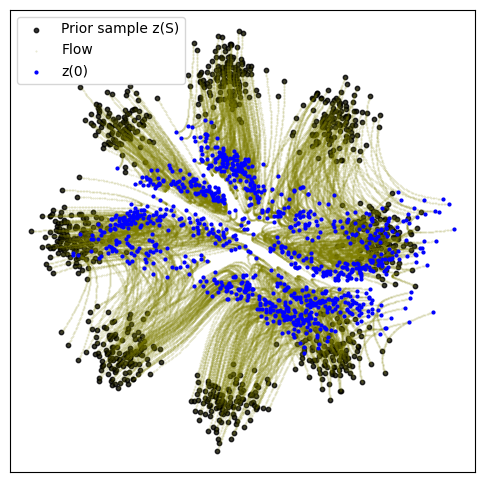

2000: loss 8.787 time 11.39


KeyboardInterrupt: 

In [38]:
%%time
dim = 2
batch_size = 256
model = VectorField(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)
    t = torch.rand(x0.shape[0]).type_as(x0)

    # Lines to solve for
    xt = x0 * (1 - t.unsqueeze(1)) + x1 * t.unsqueeze(1)
    ut = x1 - x0
    vt = model(t, xt)
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()

    if (k + 1) % 1000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = SimpleODE(model)
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())

우리는 `torchdyn.core.NeuralODE` 클래스를 사용하여 더 일반적이고 복잡한 솔버를 사용할 수 있습니다. 자세한 내용은 [NeuralODE](https://github.com/DiffEqML/torchdyn/blob/95cc74b0e35330b03d2cd4d875df362a93e1b5ea/torchdyn/core/neuralde.py#L29) 클래스 코드를 확인하세요. 가장 흥미로운 것은 `solver`의 선택입니다.

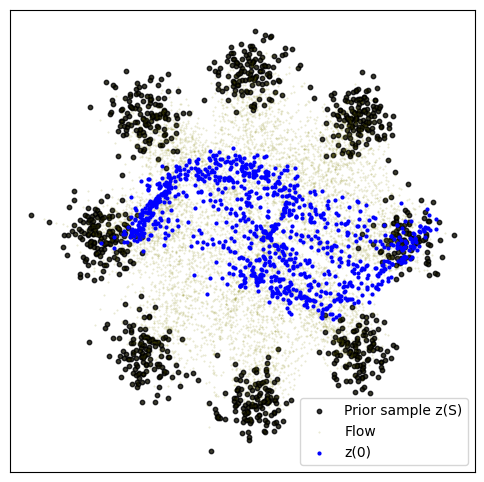

In [43]:
from torchdyn.core import NeuralODE
node = NeuralODE(model, solver="euler")
with torch.no_grad():
    traj = node.trajectory(
        sample_8gaussians(1024),
        t_span=torch.linspace(0, 1, 10),
    )
    plot_trajectories(traj.cpu().numpy())

위에서 볼 수 있듯이, 제안된 방법은 샘플을 생성하는 데 매우 잘 작동합니다. 그러나 경로는 다소 곡선입니다. 이러한 경로는 효율적이지 않으며 더 곧은 경로보다 추론 시간이 더 오래 걸립니다. 더 곧은 경로를 얻기 위해 다른 분포 $q$를 선택할 수 있습니다.

# 최적 운송 (Optimal Transport)

더 곧은 경로를 얻기 위해 최적 운송(OT) 이론을 활용할 수 있습니다. 실제로 [(Peyré et al., chapter 7)](https://arxiv.org/abs/1803.00567)에서 논의된 바와 같이, OT 문제는 최소 경로 길이 문제로 재구성될 수 있습니다. 따라서 우리는 이 속성을 활용하여 더 빠른 추론 과정으로 이어지는 더 곧은 흐름을 생성하고자 합니다.

불행히도 대규모 데이터 세트의 경우 $\Pi$를 계산하는 것이 불가능하므로 대신 미니배치 근사에 의존합니다(미니배치 OT 및 그 결합에 대한 참조는 [(Fatras et al.)](https://proceedings.mlr.press/v108/fatras20a.html) 참조). 그럼에도 불구하고 미니배치 OT 결합은 아래와 같이 좋은 성능으로 이어지며, 미니배치 OT에 대한 더 긴 논의는 TorchCFM 노트북 **The_unreasonable_performance_of_minibatch_OT**를 참조하시기 바랍니다.

In [ ]:
def exact_ot(x0, x1):
    import scipy
    N = x0.shape[0]
    # pairwise distance
    cost = (torch.cdist(x0, x1) ** 2).cpu()
    _, col_ind = scipy.optimize.linear_sum_assignment(cost)
    pi_x0 = x0[col_ind]
    pi_x1 = x1
    return pi_x0, pi_x1

5000: loss 0.202 time 54.84


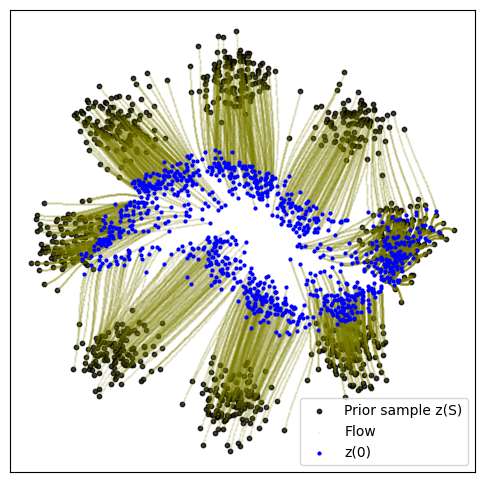

10000: loss 0.105 time 54.73


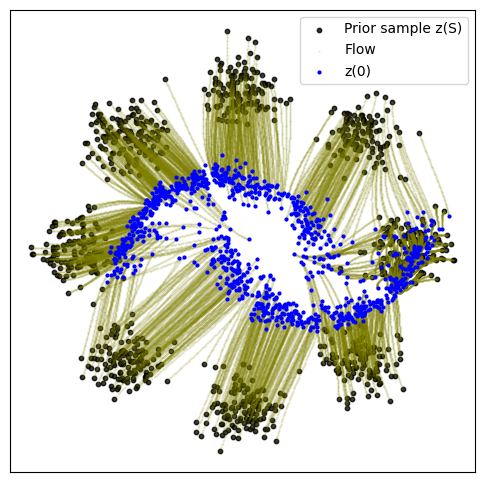

15000: loss 0.140 time 53.04


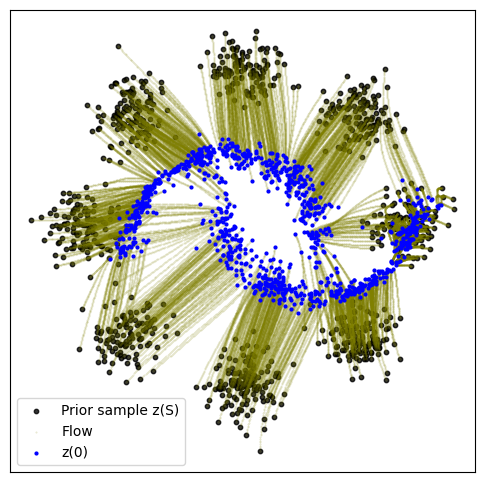

20000: loss 0.071 time 52.92


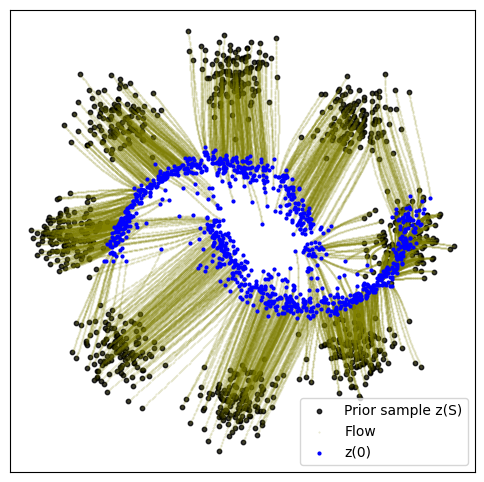

CPU times: user 3min 32s, sys: 8.5 s, total: 3min 40s
Wall time: 3min 36s


In [ ]:
%%time
dim = 2
batch_size = 256
model = VectorField(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)
    # Draw samples from OT plan
    x0, x1 = exact_ot(x0, x1)
    t = torch.rand(x0.shape[0]).type_as(x0)
    xt = x0 * (1 - t.unsqueeze(1)) + x1 * t.unsqueeze(1)
    ut = x1 - x0
    vt = model(t, xt)
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            model, solver="dopri5", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())

### 도전 과제: 사인파 스케줄 구현하기
Albergo 등은 사인파 시간 스케줄이 도움이 된다는 것을 발견했습니다. 특히 다음 보간법을 사용하는 것입니다.
$$x_t = \cos \left (\frac{\pi t}{2} \right )x_0 + \sin \left (\frac{\pi t}{2} \right ) x_1$$

이 $x_t$를 생성하는 올바른 $u_t$를 유도하고 아래에 구현해 보세요.

이 스케줄의 멋진 점은 *분산이 보존된다(variance preserving)*는 것입니다. 즉, $Var(p_0) = Var(p_1) = V$이면 모든 $t$에 대해 $Var(p_t) = V$입니다.

In [ ]:
%%time
dim = 2
batch_size = 256
model = VectorField(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)
    # Draw samples from OT plan
    x0, x1 = exact_ot(x0, x1)
    t = torch.rand(x0.shape[0]).type_as(x0)
    tt = t.unsqueeze(1)
    #xt = x0 * (1 - t.unsqueeze(1)) + x1 * t.unsqueeze(1)
    #ut = x1 - x0
    xt = torch.cos(math.pi / 2 * tt) * x0 + torch.sin(math.pi / 2 * tt) * x1
    ut = math.pi / 2 * (torch.cos(math.pi / 2 * tt) * x1 - torch.sin(math.pi / 2 * tt) * x0)
    vt = model(t, xt)
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            model, solver="dopri5", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())